In [3]:
#### kusto query public server

import pandas as pd
from azure.kusto.data import KustoClient, KustoConnectionStringBuilder, ClientRequestProperties
from azure.kusto.data.helpers import dataframe_from_result_table
from azure.kusto.data.exceptions import KustoServiceError
import traceback
import logging
import time

class KustoQuery(object):
    def __init__(self, **kwargs):        
        # self.client = None
        # self.kcsb = None
        # initialize client
        self.get_kusto_client()
        
    def get_kusto_client(self, **kwargs):
        import urllib3
        urllib3.disable_warnings()
    
        # self.cluster = kwargs.get('cluster', 'https://deepicm.westus2.kusto.windows.net')
        # self.cluster = 'https://msraaiops.eastus.kusto.windows.net'
        KustoCluster = 'https://modeldqasprodeus2.eastus.kusto.windows.net/' #'https://msraaiops.eastus.kusto.windows.net'
        
        self.db = kwargs.get('database', 'Shared')#'WorkloadProfiling')
        self.db = 'modeldqaseus2db'
        # self.application_name = kwargs.get('application_name', "67862165-cbdc-4811-bb83-d6d945a98b6b")
        # self.AAD_tenant_id = kwargs.get('AAD_tenant_id', '72f988bf-86f1-41af-91ab-2d7cd011db47')     
   
        # self.application_name = kwargs.get('application_name', "549d2a15-4a98-4fee-becb-773e531b0f7c")
        # self.AAD_tenant_id = kwargs.get('AAD_tenant_id', '72f988bf-86f1-41af-91ab-2d7cd011db47')

        # ClientId = self.application_name
        # ClientSecret = self.application_pwd
        # AADTenantId = self.AAD_tenant_id
        
        # KustoCluster = self.cluster
        #kcsb = KustoConnectionStringBuilder.with_aad_device_authentication(KustoCluster) ### use this one to access via AAD
        kcsb = KustoConnectionStringBuilder.with_az_cli_authentication(KustoCluster)
        #kcsb = KustoConnectionStringBuilder.with_aad_application_key_authentication(KustoCluster, ClientId, ClientSecret, AADTenantId)
        kusto_client = KustoClient(kcsb)
        kusto_client._session.verify = False
        self.kcsb = kcsb
        self.client = kusto_client 
        
    def query(self, kql=None, return_type='dataframe'):
        if self.client is None:
            self.get_kusto_client()
        try:
            response = self.client.execute(self.db, kql)
            res = response.primary_results[0]
            if return_type == 'dataframe':
                return dataframe_from_result_table(res)
        except KustoServiceError as error:
            print("Error:",error)
            print('Retrying after sleeping for 10 sec..')
            #time.sleep(600)
            time.sleep(10)
            
            response = self.client.execute(self.db, kql)
            res = response.primary_results[0]
            if return_type == 'dataframe':
                return dataframe_from_result_table(res)
            else:
                return None
            # print("KustoServiceError: ", error)
            #logging.getLogger().warn(f'exception error = {error}, kql = {kql}')
            #logging.getLogger().warn(traceback.format_exc())
            #return None

In [70]:
query = """
let lastIndexof = (input:string, lookup: string) {
    strlen(input) - indexof(reverse(input), reverse(lookup)) - strlen(lookup)
};
let _startTime = datetime(2024-06-23T00:00:00Z);
let _endTime = datetime(2024-06-30T00:00:00Z);
let _regions = dynamic(['eastus', 'eastus2', 'centralus', 'northcentralus', 'southcentralus', 'westcentralus', 'westus', 'westus2', 'westus3']);
LLMApiRequestTracingEvent_Global
| where TIMESTAMP between (['_startTime'] .. ['_endTime'])
| where HttpResponseStatusCode == 200 and AOAIHttpResponseStatusCode == 200
| extend splitted = split(DeploymentName, '-')
| extend DeploymentRegion = tostring(splitted[0])
| extend ModelName = tostring(splitted[1])
| project-away splitted
| where DeploymentRegion in (_regions)
| extend modver = substring(DeploymentName, indexof(DeploymentName, '-') + 1, lastIndexof(DeploymentName, '-') - indexof(DeploymentName, '-') - 1)
| extend proddev = substring(ResolvedModelName, 0, indexof(ResolvedModelName, '-'))
| extend lio = lastIndexof(DeploymentName, '-')
| summarize count() by modver, proddev
"""

In [71]:
kq = KustoQuery()
df = kq.query(kql=query)
print(df.head())

            modver proddev     count_
0  gpt4-turbo-1106    prod    2591538
1  gpt35turbo-0125     dev    1247057
2  gpt35turbo-0125    prod  153531020
3        gpt4-1106     dev     539092
4  gpt4-turbo-1106     dev     558200


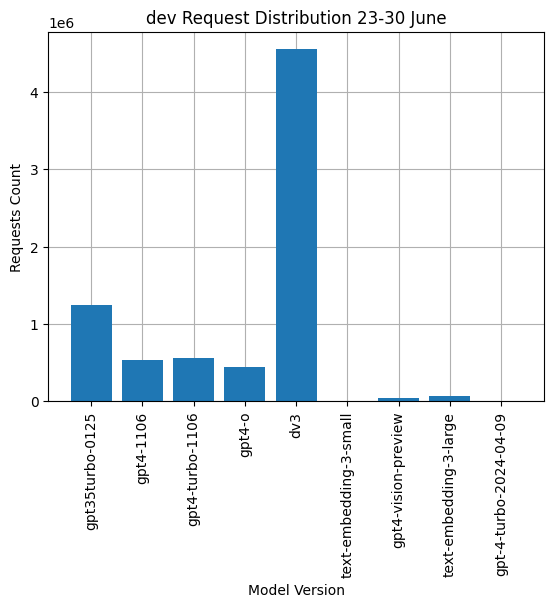

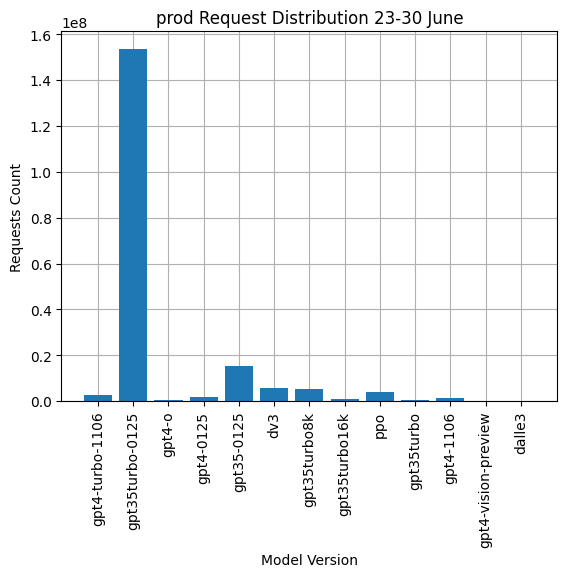

In [73]:
import matplotlib.pyplot as plt
plt.rcParams['axes.axisbelow'] = True

for type in ['dev', 'prod']:
    # plt.figure(figsize=(16,9), dpi=150)
    dfa = df[df['proddev'] == type]
    plt.bar(dfa['modver'], dfa['count_'], zorder=1)
    plt.xlabel('Model Version')
    plt.xticks(rotation=90)
    plt.ylabel('Requests Count')
    plt.title(f'{type} Request Distribution 23-30 June')
    plt.grid(zorder=0)
    plt.show()

In [27]:
import pandas as pd

In [32]:
df = pd.read_csv('periodicity.txt')


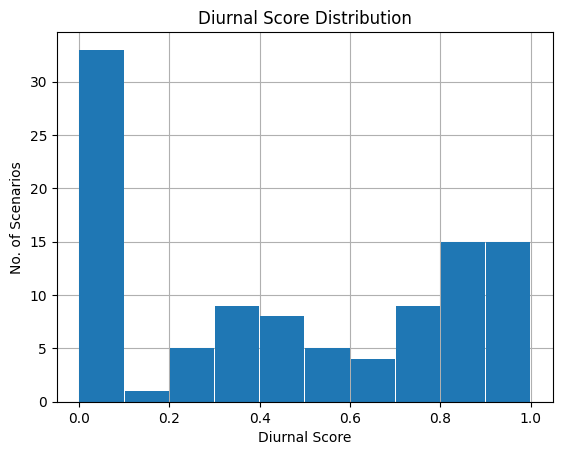

In [45]:
import matplotlib.pyplot as plt
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
plt.hist(df['score'], bins=bins, rwidth=0.98)
plt.xlabel('Diurnal Score')
plt.ylabel('No. of Scenarios')
plt.title('Diurnal Score Distribution')
plt.grid()
plt.show()

In [1]:
query = """
let _startTime = datetime(2024-06-23T00:00:00Z);
let _endTime = datetime(2024-06-30T00:00:00Z);
let _regions = dynamic(['eastus', 'eastus2', 'centralus', 'northcentralus', 'southcentralus', 'westcentralus', 'westus', 'westus2', 'westus3']);
LLMApiRequestTracingEvent_Global
| where TIMESTAMP between (['_startTime'] .. ['_endTime'])
| where HttpResponseStatusCode == 200 and AOAIHttpResponseStatusCode == 200
| extend splitted = split(DeploymentName, '-')
| extend DeploymentRegion = tostring(splitted[0])
| extend ModelName = tostring(splitted[1])
| project-away splitted
| extend proddev = substring(ResolvedModelName, 0, indexof(ResolvedModelName, '-'))
| where DeploymentRegion in (_regions)
| where ScenarioName in (dynamic(['{scenario}']))
| where proddev in (dynamic(['{proddev}']))
| summarize RequestCount = count() by bin(TIMESTAMP, 1s) 
| summarize percentile(RequestCount, 95) by bin(TIMESTAMP, 1h)
"""

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 9))

for scenario, proddev in [('EnterpriseSydney', 'prod'), ('EnterpriseSydney', 'dev')]:
    q = query.format(scenario=scenario, proddev=proddev)
    kq = KustoQuery()
    df = kq.query(kql=q)
    df = df.sort_values('TIMESTAMP')
    plt.plot(df['TIMESTAMP'], df['percentile_RequestCount_95'], label=f"{scenario} {proddev}", markersize=5)

# Set the x-axis label
plt.xlabel('Timestamp', fontsize=12)

# Set the y-axis label
plt.ylabel('95%ile RPS', fontsize=12)

# Set the title
plt.title(f'RPS of EnterpriseSydney (prod and dev) Scenario 23-30 June', fontsize=15)

# Show the legend
plt.legend()
plt.xlim(df['TIMESTAMP'].min(), df['TIMESTAMP'].max())
plt.grid()
# Show the plot
plt.show()

Error: Failed to process network request for the endpoint: https://modeldqasprodeus2.eastus.kusto.windows.net/v1/rest/auth/metadata
Retrying after sleeping for 10 sec..


KustoNetworkError: Failed to process network request for the endpoint: https://modeldqasprodeus2.eastus.kusto.windows.net/v1/rest/auth/metadata

<Figure size 1600x900 with 0 Axes>

eastus eastus
eastus centralus
eastus westus
centralus eastus
centralus centralus
centralus westus
westus eastus
westus centralus
westus westus


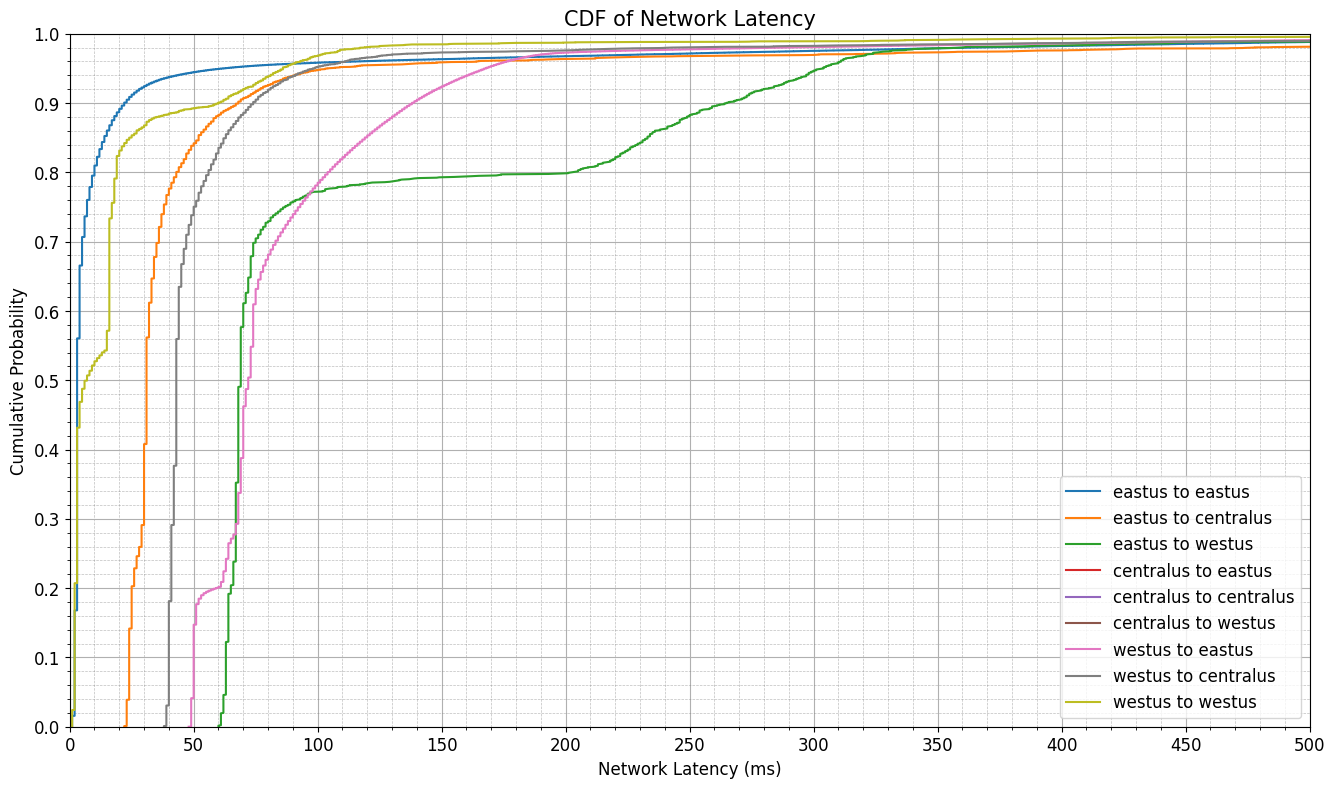

In [34]:
import numpy as np
import matplotlib.pyplot as plt

query = """
cluster('modeldqasprodeus2.eastus').database('modeldqaseus2db').LLMApiRequestTracingEvent_Global
| where TIMESTAMP > ago(2h)
| where HttpResponseStatusCode == 200
| where ResolvedModelName startswith "prod"
| where Tenant startswith "prod"
| where AoaiApiFirstTokenTimeMs <> 0
| join kind=innerunique
(cluster('cogsvc.kusto.windows.net').database('Platform').TraceCallResult
| where PreciseTimeStamp >ago(2h)) on $left.APIMRequestId == $right.RequestId
| extend AMLFrontDoorLatency = Latency/10000
| extend NetworkLatency = AoaiApiFirstTokenTimeMs-AMLFrontDoorLatency
| where Tenant contains "-{src}"
| where DeploymentName startswith "{dst}-"
| project NetworkLatency, DeploymentName, Tenant
"""
plt.figure(figsize=(16, 9))
regions = ['eastus', 'centralus', 'westus']
for src in regions:
    if src not in dp:
        dp[src] = {}
    for dst in regions:
        print(src, dst)
        if dst in dp[src]:
            df = dp[src][dst]
        else:
            q = query.format(src=src, dst=dst)
            kq = KustoQuery()
            df = kq.query(kql=q)
            dp[src][dst] = df

        # Sort the NetworkLatency values in ascending order
        sorted_latency = np.sort(df['NetworkLatency'])

        # Calculate the cumulative probabilities
        cumulative_prob = np.arange(len(sorted_latency)) / float(len(sorted_latency))

        plt.plot(sorted_latency, cumulative_prob, label=f'{src} to {dst}')

# Set the x-axis label
plt.xlabel('Network Latency (ms)',fontsize=12)

# Set the y-axis label
plt.ylabel('Cumulative Probability', fontsize=12)

# Set the title
plt.title('CDF of Network Latency', fontsize=15)
plt.legend(fontsize=12)
plt.xlim(0, 500)
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=12)
plt.xticks(np.arange(0, 501, 50), fontsize=12)
plt.minorticks_on()
plt.grid(which='minor', linestyle='--', linewidth='0.5', color='gray', alpha=0.5)
plt.grid()
plt.show()

In [38]:
scenarios = pd.read_csv('periodicity.csv')
iw = list(scenarios[scenarios['score'] > 0.5]['scenario'].values)

In [41]:
for scenario in iw:
    print(f"'{scenario}', ", end='')

'Feed-File', 'EnterpriseSydney', 'AI Notes in Recap', 'Outlook Suggested Replies', 'Suggestion Chip', 'Web Tab For M365', 'Teams Co-Pilot (New)', 'BizChat-Proactive', 'Augloop-Chat (PowerPoint Copilot)', 'Word Copilot Summarization - Proactive', 'Augloop-Chat (Word Copilot)', 'PPT Visual Summary Proactive', 'Augloop-Remake (Word)', 'Viva Engage - Summarization', 'Short Meeting Summary', 'Augloop-Chat (Excel Copilot)', 'Outlook-Elaborate', 'Word to PPT Deck Conversion (Project Bumblebee)', 'PPT Summary Proactive', 'Augloop-Storyteller (PowerPoint)', 'Augloop-Start (Word)', 'BizChat Echo Traffic', 'Teams Chat Summarization (CommCopilot)', 'PPT Copilot Multimodal Comprehension', 'Outlook Thread Summarize', 'Stream-Copilot', 'b9ae273f-77be-4b66-94a2-69d3c8b30aae', 'PPT - Conversational Chat', 'Message-Post (Teams Chat Compose)', 'Search - People', 'Feed–File (Pre-warm)', 'Word - Conversational Chat', 'Outlook Email Coach / Feedback', 'Alchemy', 'Analysis with Chat (Excel)', 'Augloop-Summar